In [18]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [19]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%autoreload 2

In [21]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils

In [22]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml']

In [23]:
# config

In [25]:
tiling_size = 64
for fp in config_fps[1:2]:
    new_fp = fp.replace('config.yaml', 'config_xenium_multiplex.yaml')
    config = yaml.safe_load(open(fp))
    for entry in config:
        sid = entry['id']
        for mapping in entry['data']:
            if mapping['dtype'] == 'multiplex':
                mapping['dtype'] = 'multiplex_codex'
            if mapping['dtype'] == 'xenium':
                directory = '/'.join(mapping['filepath'].split('/')[:-1])
                adata = sc.read_h5ad(mapping['filepath'])
                data = rearrange(xenium.to_multiplex(adata, tiling_size=tiling_size), 'h w c -> c h w')
                data = np.log1p(data)
                channels = adata.var.index.to_list()
                
                # quick hack for now
                if 'HT206B1' in directory:
                    data = data[:, :102, :]
                
                out_fp = os.path.join(directory, f'{sid}_multiplex.ome.tiff')
                print(sid, out_fp, data.shape)
                multiplex.write_basic_ome_tiff(
                    out_fp, data, channels, pix_per_micron=1. / tiling_size
                )
                
                mapping['filepath'] = out_fp
                mapping['dtype'] = 'multiplex'
    yaml.safe_dump(config, open(new_fp, 'w'))

s0 /data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s0_multiplex.ome.tiff (477, 182, 161)
s1 /data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s1_multiplex.ome.tiff (477, 182, 161)
s2 /data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s2_multiplex.ome.tiff (477, 182, 161)
s4 /data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-25943/s4_multiplex.ome.tiff (477, 182, 161)


In [62]:
a2 = sc.read_h5ad('/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s7_xenium.h5ad')
a2.uns['spatial']['key']['images']['hires'].shape

(3411, 2847)

In [69]:
def to_multiplex(adata, tiling_size=64):
    size = visium.get_fullres_size(adata)
    n_rows, n_cols = size[-2] // tiling_size + 1, size[-1] // tiling_size + 1
    pts = adata.obsm['spatial'][:, [1, 0]]

    img = np.zeros((n_rows, n_cols, adata.shape[1]))
    for r in range(n_rows):
        r1, r2 = r * tiling_size, (r + 1) * tiling_size
        row_mask = ((pts[:, 0] >= r1) & (pts[:, 0] < r2))
        row_adata, row_pts = adata[row_mask], pts[row_mask]
        for c in range(n_cols):
            c1, c2 = c * tiling_size, (c + 1) * tiling_size
            col_mask = ((row_pts[:, 1] >= c1) & (row_pts[:, 1] < c2))
            img[r, c] = row_adata[col_mask].X.sum(0)
    return img  

In [63]:
a = sc.read_h5ad('/data/estorrs/mushroom/data/projects/xenium_grant/registered/HT206B1/s0_xenium.h5ad')
a

AnnData object with n_obs × n_vars = 115764 × 477
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'transcripts'
    obsm: 'spatial'

In [70]:
multi = to_multiplex(a)
multi.shape

(103, 95, 477)

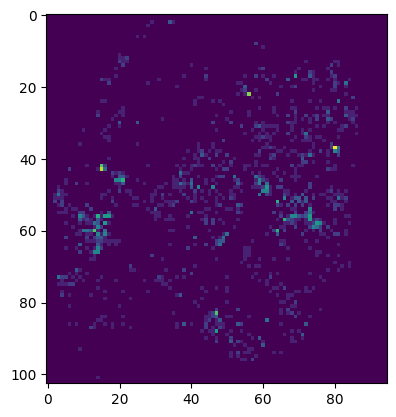

In [72]:
plt.imshow(multi[..., 1])

In [34]:
tiling_size = 64
size = visium.get_fullres_size(a)
n_rows, n_cols = size[-2] // tiling_size + 1, size[-1] // tiling_size + 1
size, n_rows, n_cols
# pad_h, pad_w = tiling_size - size[-2] % tiling_size, tiling_size - size[-1] % tiling_size
# pad_top, pad_left, pad_bottom, pad_right = pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2
# pad_top, pad_left, pad_bottom, pad_right

((6530, 6054), 103, 95)

In [26]:
df = a.uns['transcripts'].copy()
df = df[df['cell_id']!='UNASSIGNED']
pts = df[['y_location', 'x_location']].values
genes = df['feature_name'].to_numpy()
pts.shape, genes.shape

((20561285, 2), (20561285,))

In [48]:
img = np.zeros((n_rows, n_cols, len(channels)))
for r in range(n_rows):
    r1, r2 = r * tiling_size, (r + 1) * tiling_size
    row_mask = ((pts[:, 0] >= r1) & (pts[:, 0] < r2))
    row_genes, row_pts = genes[row_mask], pts[row_mask]
    for c in range(n_cols):
        c1, c2 = c * tiling_size, (c + 1) * tiling_size
        col_mask = ((row_pts[:, 1] >= c1) & (row_pts[:, 1] < c2))
        gs = row_genes[col_mask]
        counts = Counter(gs)
        img[r, c] = np.asarray([counts.get(x, 0) for x in channels])
        
        

In [49]:
img.shape

(103, 95, 377)

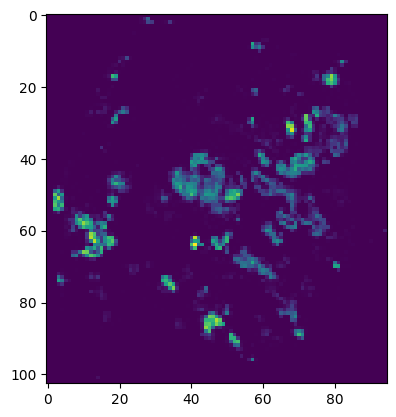

In [50]:
plt.imshow(img[..., channels.index('EPCAM')])